<a href="https://colab.research.google.com/github/shramkoartem/TableGraphRCNN/blob/dev/notebooks/Table_Detection_Dataset_w_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# https://github.com/sgrpanchal31/table-detection-dataset/archive/master.zip
# https://github.com/sgrpanchal31/table-detection-dataset - source

In [30]:
!wget https://github.com/sgrpanchal31/table-detection-dataset/archive/master.zip
!ls

--2021-01-26 09:41:32--  https://github.com/sgrpanchal31/table-detection-dataset/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/sgrpanchal31/table-detection-dataset/zip/master [following]
--2021-01-26 09:41:32--  https://codeload.github.com/sgrpanchal31/table-detection-dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.1’

master.zip.1            [        <=>         ]  29.74M  18.1MB/s    in 1.6s    

2021-01-26 09:41:34 (18.1 MB/s) - ‘master.zip.1’ saved [31182443]

data  master.zip  master.zip.1	sample_data


In [31]:
!unzip -q master.zip
!mv table-detection-dataset-master data

In [32]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2


from skimage import io, transform
import skimage

plt.ion()


In [33]:
IMG_PATH = "data/images/"

train_bbox_df = pd.read_csv("data/train.csv", header=None)
val_bbox_df = pd.read_csv("data/val.csv", header=None)

print(len(os.listdir(IMG_PATH)))
print(len(train_bbox_df))
print(len(val_bbox_df))

403
418
100


In [34]:
train_bbox_df.iloc[:5,1:-1]

,1,2,3,4
0,770,946,2070,2973
1,270,1653,2280,2580
2,303,343,2273,2953
3,664,1782,1814,2076
4,704,432,1744,1552


In [35]:
n =5 

img_name = train_bbox_df.iloc[n,0]
bbox = train_bbox_df.iloc[n,1:-1]
bbox = np.asarray(bbox)
print(bbox)


[682 1740 1800 2440]


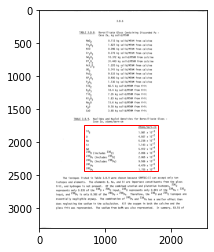

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image


def show_bbox(image, bbox):
  """ Show image with bbox """
  plt.imshow(image)

  # draw rectangle
  xmin, ymin, xmax, ymax = bbox
  w = xmax - xmin
  h = ymax - ymin

  rect = Rectangle((xmin, ymin), w, h,
                   linewidth=1,edgecolor='r',
                   facecolor='none')
  ax = plt.gca()
  ax.add_patch(rect)
  plt.pause(0.001)


im = Image.open(os.path.join(IMG_PATH, img_name))
show_bbox(im, bbox)



In [37]:
gray_img = skimage.io.imread(os.path.join(IMG_PATH, img_name))

In [38]:
np.expand_dims(im, axis=2).shape

(3300, 2544, 1)

In [53]:
import cv2

color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)

color_img.astype(float)

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

# Dataset

In [54]:
class TableDataset(Dataset):
  """ Table Detection Dataset """
  def __init__(self, img_path, csv_file, 
               transforms=False, 
               drop_duplicates=False,
               grayscalse_to_color=True):
    """        
    Args:
      img_path (string): Directory containing images
      csv_file (string): Path to the csv file containig annotations
      transform (callable, optional): Transforms to be applied
      drop_dublicates (boolean, optional): Removes rows that contain
                           more than one bounding box in the image 
      grayscalse_to_color (boolean, optional): converts grayscalse
                          image of shape (w, h) into a 3 channels
                          image of shape (w, h, c)
      
    """
    self.img_path = img_path
    self.bbox_frame = pd.read_csv(csv_file, header=None)
    self.transforms = transforms
    self.grayscalse_to_color = grayscalse_to_color

    if drop_duplicates:
      self.bbox_frame = self.bbox_frame.drop_duplicates(subset=0,
                                                        keep=False)

  def __len__(self):
    return len(self.bbox_frame)

  def __getitem__(self, idx):
    """
    Returns sample at index 'idx'
    Returns:
      {"image": image, "bbox": bbox} (dict)
    """
    if torch.is_tensor(idx):
      idx = idx.tolist()

    # load image
    img_name = self.bbox_frame.iloc[idx,0]
    image = skimage.io.imread(os.path.join(self.img_path, img_name))
    # since the dataset is grayscale, we need to add channels
    # since models require 3 channels input for color
    if self.grayscalse_to_color:
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = image.astype(float)

    # load coordinates of a bounding box
    bbox = self.bbox_frame.iloc[idx,1:-1]
    bbox = np.array(bbox)
    sample = {'image': image, "bbox": bbox}

    if self.transforms:
      sample = self.transforms(sample)

    return sample




0 (3300, 2544, 3) (4,)


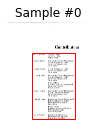

1 (3300, 2544, 3) (4,)


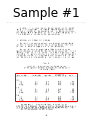

2 (3300, 2544, 3) (4,)


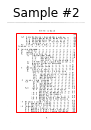

3 (3300, 2560, 3) (4,)


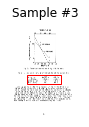

In [41]:
# test

ds = TableDataset(img_path = IMG_PATH, csv_file="data/train.csv")

fig = plt.figure()

for i in range(len(ds)):
  sample = ds[i]

  print(i, sample["image"].shape, sample["bbox"].shape)

  ax = plt.subplot(1,4, i+1)
  plt.tight_layout()
  ax.set_title(f"Sample #{i}")
  ax.axis("off")
  show_bbox(**sample)

  if i ==3:
    plt.show()
    break

In [42]:
sample["bbox"]

array([664, 1782, 1814, 2076], dtype=object)

# Transforms

In [43]:
import skimage

class Rescale(object):
  def __init__(self, output_size):
    assert isinstance(output_size, tuple)
    self.output_size = output_size

  def __call__(self, sample):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    image, bbox = sample['image'], sample['bbox']
    xmin, ymin, xmax, ymax = bbox.tolist()
    h, w = image.shape[:2]

    new_h, new_w = self.output_size

    image = skimage.transform.resize(image, (new_h, new_w))
    bbox = bbox * [new_w / w, new_h / h,
                             new_w / w, new_h / h]

    resized_sample = {'image' : image, 'bbox' : bbox}
    return resized_sample




In [76]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {'image': torch.tensor(image, dtype=torch.float),
                'bbox': torch.tensor(bbox.tolist(), dtype=float)}

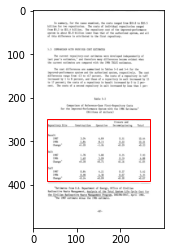

In [77]:
scale = Rescale((500,300))

imtest = scale(ds[1])

show_bbox(**imtest)

# Defining a data loader

In [78]:
data_transforms = transforms.Compose([Rescale((224, 224)),
                                      ToTensor()])

dataset_params = {x : {"img_path": "data/images",
                       "csv_file": f"data/{x}.csv",
                       "transforms" : data_transforms,
                       "drop_duplicates": True} 
                  for x in ["train", "val"]}

datasets = {x: TableDataset(**dataset_params[x]) 
            for x in ["train", "val"]}

dataloaders = {x : torch.utils.data.DataLoader(datasets[x],
                                               batch_size = 4,
                                               shuffle=True,
                                               num_workers=4)
              for x in ["train", 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}


In [71]:
# test
#next(iter(dataloaders["train"]))
# works:)

# Transfer Learning

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import torch.nn.functional as F

# Train

In [80]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10**6

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in dataloaders[phase]:
                inputs = sample["image"].to(device, dtype=torch.float)
                labels = sample["bbox"].to(device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = F.l1_loss(outputs, labels, reduction="none").sum(1)
                    loss = loss.sum()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [65]:
# finetuning the convnet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_in_features = model.fc.in_features
model.fc = nn.Linear(num_in_features, 4)

model = model.to(device)

parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.SGD(parameters, lr=0.006)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)




In [ ]:
model_ft = train_model(model, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 404.7971
val Loss: 353.0919

Epoch 1/24
----------
train Loss: 397.2520
val Loss: 409.0602

Epoch 2/24
----------
train Loss: 395.4948
val Loss: 397.5399

Epoch 3/24
----------
train Loss: 380.2005
val Loss: 363.3342

Epoch 4/24
----------
train Loss: 371.1731
val Loss: 453.8435

Epoch 5/24
----------
train Loss: 341.5824
val Loss: 284.7162

Epoch 6/24
----------
train Loss: 335.3495
val Loss: 275.6946

Epoch 7/24
----------
train Loss: 323.2746
val Loss: 276.9386

Epoch 8/24
----------
train Loss: 320.9903
val Loss: 280.3691

Epoch 9/24
----------
train Loss: 320.9328
val Loss: 317.9195

Epoch 10/24
----------
train Loss: 317.5084
val Loss: 275.9621

Epoch 11/24
----------
train Loss: 309.8668
val Loss: 269.9741

Epoch 12/24
----------
train Loss: 307.8110
val Loss: 255.8697

Epoch 13/24
----------
train Loss: 301.2687
val Loss: 267.0320

Epoch 14/24
----------
train Loss: 305.6733
val Loss: 263.0528

Epoch 15/24
----------
train Loss: 304.3479
val Lo

In [83]:
torch.save(model.state_dict(), "resnet18_table.pt")